<a href="https://colab.research.google.com/github/MarcoBarroca/VI_EAFEXP_Proj3/blob/main/projetos/Draft_marco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

from tqdm import tqdm, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import backend as K

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [54]:
WORK_DIR = '/content/drive/MyDrive/DataP03/'
METADATA_TRAIN='/content/drive/MyDrive/DataP03/plasticc_train_metadata.csv.gz'
DATA_TRAIN='/content/drive/MyDrive/DataP03/plasticc_train_lightcurves.csv.gz'
DATA_TEST='/content/drive/MyDrive/DataP03/plasticc_test_metadata.csv.gz'
DATA_EXTRA='/content/drive/MyDrive/DataP03/plasticc_lightcurves_extra.csv.gz'

In [55]:

train_data = pd.read_csv(DATA_TRAIN,
)

test_data=pd.read_csv(DATA_TEST)
data_extra=pd.read_csv(DATA_EXTRA)
metadata_train=pd.read_csv(METADATA_TRAIN)


In [64]:
metadata_train

,object_id,ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,...,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
0,615,349.0461,-61.9438,1,0.000,0.000,0.000,-9.000,0.017,92,...,0.0,0.0,59570.000,69,484.7,3286.7,3214.1,3039.7,2854.5,2837.0
1,713,53.0859,-27.7844,1,1.818,1.627,0.255,45.406,0.007,88,...,0.0,0.0,59570.000,34,108.7,117.7,119.9,149.6,147.9,150.5
2,730,33.5742,-6.5796,1,0.232,0.226,0.016,40.256,0.021,42,...,0.0,0.0,60444.379,9,0.0,0.0,0.0,0.0,0.0,0.0
3,745,0.1899,-45.5867,1,0.304,0.281,1.152,40.795,0.007,90,...,0.0,0.0,60130.453,38,0.0,0.0,0.0,0.0,0.0,0.0
4,1124,352.7113,-63.8237,1,0.193,0.241,0.018,40.417,0.024,90,...,0.0,0.0,60452.641,1,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7843,130739978,26.7188,-14.9403,0,0.000,0.000,0.000,-9.000,0.013,65,...,0.0,0.0,59570.000,18232,26.4,267.6,742.8,3295.1,6047.5,7955.2
7844,130755807,120.1013,-62.6967,0,0.172,2.561,1.115,46.611,0.136,90,...,0.0,0.0,60056.809,14934,0.0,0.0,0.0,0.0,0.0,0.0
7845,130762946,203.1081,-55.6821,0,0.000,0.000,0.000,-9.000,0.430,16,...,0.0,0.0,59570.000,47805,83.8,1124.7,1445.1,1191.2,848.9,382.5
7846,130772921,79.1016,-35.5018,0,0.000,0.000,0.000,-9.000,0.034,65,...,0.0,0.0,59570.000,22240,1.9,14.4,49.4,244.3,534.8,897.2


In [93]:
train_data

,object_id,mjd,passband,flux,flux_err,detected_bool
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1
...,...,...,...,...,...,...
1421700,130779836,60555.9838,4,-39.881969,46.477093,0
1421701,130779836,60560.0459,1,14.894439,18.947685,0
1421702,130779836,60571.0225,5,30.593130,50.695290,0
1421703,130779836,60585.9974,4,-23.471439,44.819859,0


In [77]:
if metadata_train['object_id']==615:

ValueError: ignored

In [94]:
train_data_array=np.array(train_data)[:, :-1]

In [37]:
test

array([[ 6.15000000e+02,  5.97504229e+04,  2.00000000e+00,
        -5.44810303e+02,  3.62295200e+00],
       [ 6.15000000e+02,  5.97504306e+04,  1.00000000e+00,
        -8.16434326e+02,  5.55337000e+00],
       [ 6.15000000e+02,  5.97504383e+04,  3.00000000e+00,
        -4.71385529e+02,  3.80121300e+00],
       ...,
       [ 1.30779836e+08,  6.05710225e+04,  5.00000000e+00,
         3.05931300e+01,  5.06952900e+01],
       [ 1.30779836e+08,  6.05859974e+04,  4.00000000e+00,
        -2.34714390e+01,  4.48198590e+01],
       [ 1.30779836e+08,  6.05880372e+04,  0.00000000e+00,
        -4.12142640e+01,  5.16651230e+01]])

In [39]:
test[0][0]

615.0

In [105]:
time=[]
flux=[]
flux_error=[]
for i in range(len(train_data_array)):
  if train_data_array[i][0]==713 and train_data_array[i][2]==0:
    time.append(test[i][1])
    flux.append(test[i][3])
    flux_error.append(test[i][4])

In [106]:
train_data.iloc[0]

object_id          615.000000
mjd              59750.422900
passband             2.000000
flux              -544.810303
flux_err             3.622952
detected_bool        1.000000
Name: 0, dtype: float64

In [107]:
time=time-np.min(time)

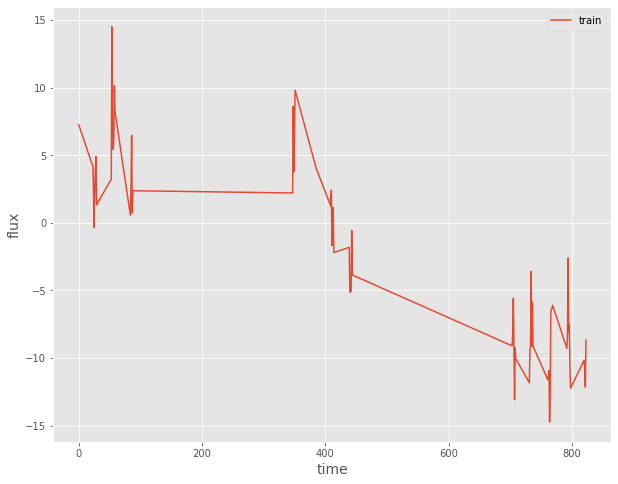

In [108]:
end=600
plt.figure(figsize=(10,8))
#plt.plot(time[:end],flux[:end], label='train')
plt.plot(time,flux, label='train')

plt.xlabel('time', fontsize=14)
plt.ylabel('flux', fontsize=14)
plt.legend()

In [92]:
metadata_train_array=np.array(metadata_train)[:,:-1]
for  i in range(len(metadata_train_array)):
  if metadata_train_array[i][0]==713:
    print(metadata_train_array[i][11])


1.0


In [88]:
metadata_train_array=np.array(metadata_train)[:,:-1]

In [109]:
metadata_train

,object_id,ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,...,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
0,615,349.0461,-61.9438,1,0.000,0.000,0.000,-9.000,0.017,92,...,0.0,0.0,59570.000,69,484.7,3286.7,3214.1,3039.7,2854.5,2837.0
1,713,53.0859,-27.7844,1,1.818,1.627,0.255,45.406,0.007,88,...,0.0,0.0,59570.000,34,108.7,117.7,119.9,149.6,147.9,150.5
2,730,33.5742,-6.5796,1,0.232,0.226,0.016,40.256,0.021,42,...,0.0,0.0,60444.379,9,0.0,0.0,0.0,0.0,0.0,0.0
3,745,0.1899,-45.5867,1,0.304,0.281,1.152,40.795,0.007,90,...,0.0,0.0,60130.453,38,0.0,0.0,0.0,0.0,0.0,0.0
4,1124,352.7113,-63.8237,1,0.193,0.241,0.018,40.417,0.024,90,...,0.0,0.0,60452.641,1,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7843,130739978,26.7188,-14.9403,0,0.000,0.000,0.000,-9.000,0.013,65,...,0.0,0.0,59570.000,18232,26.4,267.6,742.8,3295.1,6047.5,7955.2
7844,130755807,120.1013,-62.6967,0,0.172,2.561,1.115,46.611,0.136,90,...,0.0,0.0,60056.809,14934,0.0,0.0,0.0,0.0,0.0,0.0
7845,130762946,203.1081,-55.6821,0,0.000,0.000,0.000,-9.000,0.430,16,...,0.0,0.0,59570.000,47805,83.8,1124.7,1445.1,1191.2,848.9,382.5
7846,130772921,79.1016,-35.5018,0,0.000,0.000,0.000,-9.000,0.034,65,...,0.0,0.0,59570.000,22240,1.9,14.4,49.4,244.3,534.8,897.2


In [116]:
classes=[6,15,16,42,52,53,62,64,65,67,88,90,92,95]
counts=[]
for i in range(len(classes)):
  count=np.array(metadata_train)==classes[i]
  counts.append(np.sum(count))



In [117]:
counts

[327, 1013, 1866, 2422, 381, 86, 984, 229, 1976, 434, 754, 4642, 498, 376]

Text(0, 0.5, 'classes ')

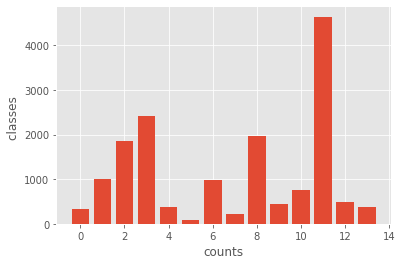

In [122]:
plt.bar(range(len(classes)),counts)
plt.xlabel('counts')
plt.ylabel('classes ')

Text(0, 0.5, 'filters ')

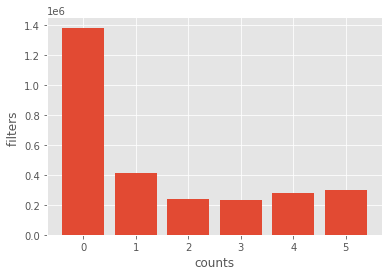

In [129]:
filters=[0,1,2,3,4,5]
counts=[]
for i in range(len(filters)):
  count=np.array(train_data)==filters[i]
  counts.append(np.sum(count))

plt.bar(range(len(filters)),counts)
plt.xlabel('counts')
plt.ylabel('filters ')

In [128]:
counts

[0, 299025]

In [134]:
obj_ids=train_data['object_id'].values
obj_ids_unique=np.unique(obj_ids)

Text(0, 0.5, 'filters ')

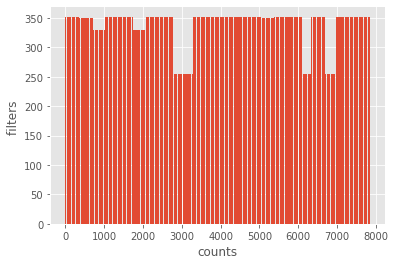

In [137]:
counts=[]
for i in range(len(obj_ids_unique)):
  count=np.array(train_data)==obj_ids_unique[i]
  counts.append(np.sum(count))

plt.bar(range(len(obj_ids_unique)),counts)
plt.xlabel('counts')
plt.ylabel('filters ')

Text(0, 0.5, 'obj_ids ')

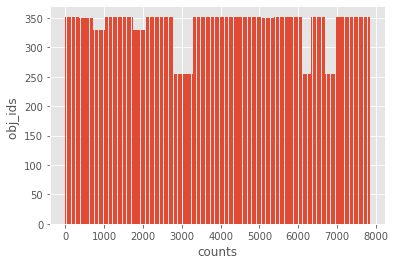

In [140]:
plt.bar(range(len(obj_ids_unique)),counts)
plt.xlabel('counts')
plt.ylabel('obj_ids ')

In [141]:
np.min(counts)

255

In [151]:
amplitudes=[]
for i in range(len(obj_ids_unique)):
  lines=train_data[train_data['object_id']==obj_ids_unique[i]]
  flux=lines['flux'].values
  amplitudes.append(abs(np.max(flux))+abs(np.min(flux)))

Text(0, 0.5, 'amplitudes ')

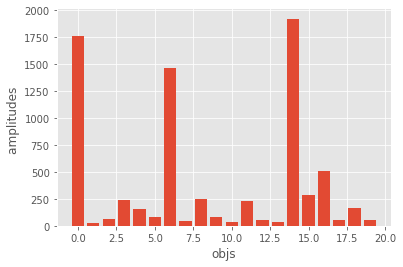

In [166]:
end=20
plt.bar(range(len(obj_ids_unique[:end])),amplitudes[:end])
#plt.bar(range(len(obj_ids_unique)),amplitudes)
plt.xlabel('objs')
plt.ylabel('amplitudes ')

In [158]:
|obj_ids_unique

array([      615,       713,       730, ..., 130762946, 130772921,
       130779836])

In [159]:
amplitudes

[1761.066406,
 29.506064000000002,
 66.46987,
 236.289675,
 160.143942,
 84.373315,
 1462.5698499999999,
 49.085574,
 245.196251,
 83.423296,
 39.651759999999996,
 232.189974,
 52.317161,
 38.639742999999996,
 1921.5093399999998,
 287.305885,
 508.183083,
 57.342017,
 168.347441,
 49.754541,
 32.928342,
 164.038946,
 151.363157,
 133.896177,
 158.20098099999998,
 265.262136,
 814.238785,
 123.994867,
 140.219883,
 317.51537599999995,
 742.55594,
 226.832465,
 159.716221,
 40.762305,
 79.48746200000001,
 2589.046985,
 192.597263,
 4133.2032469999995,
 71.41815199999999,
 95.416938,
 27.519033,
 175.819695,
 396.912867,
 39.249538,
 1002.0588799999999,
 61.21987899999999,
 3180.185058,
 71.781729,
 191.394307,
 179.057747,
 709.5299299999999,
 41.112631,
 135.059072,
 1774.729472,
 380.895976,
 60.28412,
 148.062492,
 117.949589,
 149.071135,
 270.867773,
 113.744679,
 115.03791799999999,
 439.451706,
 221.12231300000002,
 283.59263899999996,
 129.172731,
 62.351106,
 140.64793,
 119.602